In [1]:
#importing the libraries
import numpy as np
import pandas as pd
import math
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use(['seaborn-darkgrid'])

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


In [2]:
#Get the data set from finance.yahoo from start of 2012 to start of 2020
df = web.DataReader('FB', data_source='yahoo', start='2012-01-01', end='2020-01-01') 
#displaying the dataset
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-05-18,45.000000,38.000000,42.049999,38.230000,573576400,38.230000
2012-05-21,36.660000,33.000000,36.529999,34.029999,168192700,34.029999
2012-05-22,33.590000,30.940001,32.610001,31.000000,101786600,31.000000
2012-05-23,32.500000,31.360001,31.370001,32.000000,73600000,32.000000
2012-05-24,33.209999,31.770000,32.950001,33.029999,50237200,33.029999
...,...,...,...,...,...,...
2019-12-24,206.789993,205.000000,206.300003,205.119995,6046300,205.119995
2019-12-26,207.820007,205.309998,205.570007,207.789993,9350700,207.789993
2019-12-27,208.929993,206.589996,208.669998,208.100006,10284200,208.100006


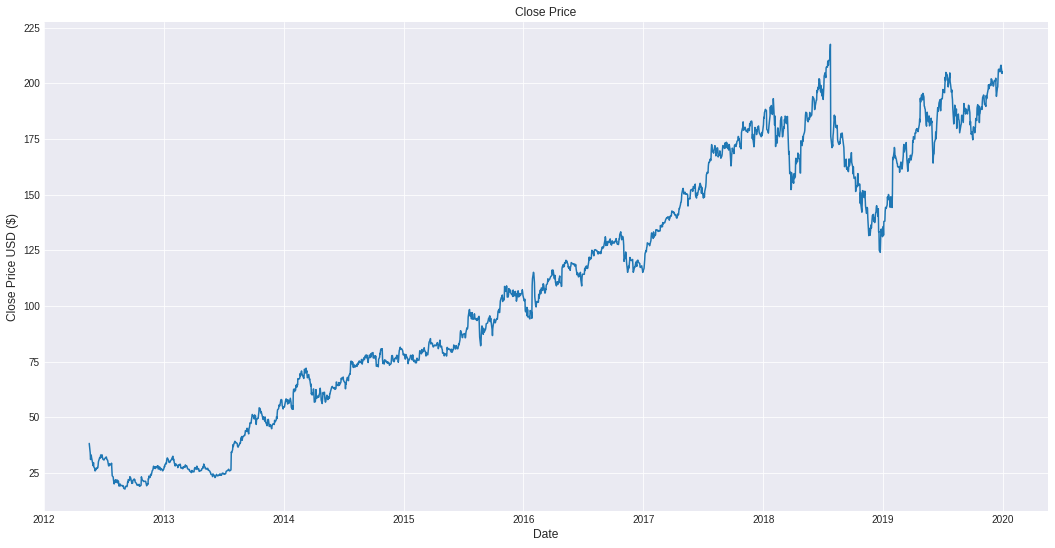

In [3]:
#Plotting the closing price of the stock for the past 8 years
plt.figure(figsize=(18,9))
plt.title('Close Price')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=12)
plt.ylabel('Close Price USD ($)',fontsize=12)
plt.show()

In [0]:
#Retreiving only closing stock values
close = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = close.values
#Get /Compute the number of rows to train the model on
train_len = math.ceil( len(dataset) *.8) 

In [0]:
#Scaling the values before fitting it in the model 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [0]:
#SCaling the data between 0 and 1
train_data = scaled_data[0:train_len  , : ]
#Dividing the data set into train and test
x_train=[]
y_train = []
for i in range(100,len(train_data)):
    x_train.append(train_data[i-100:i,0])
    y_train.append(train_data[i,0])

In [0]:
#Transform x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [0]:
#Changing the shape of the data set to fit in our model
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [0]:
#Modelling the predictor using LSTM
Predictor = Sequential()
Predictor.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
Predictor.add(LSTM(units=50, return_sequences=False))
Predictor.add(Dense(units=25))
Predictor.add(Dense(units=1))

In [0]:
#Compiling it using stochastic gradient descent optimizer called Adam 
Predictor.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
#Finally fit the model and train
Predictor.fit(x_train, y_train, batch_size=10, epochs=10)

Epoch 1/10
1434/1434 [==============================] - 14s 10ms/step - loss: 0.0057
Epoch 2/10
1434/1434 [==============================] - 13s 9ms/step - loss: 3.9741e-04
Epoch 3/10
1434/1434 [==============================] - 13s 9ms/step - loss: 5.1718e-04
Epoch 4/10
1434/1434 [==============================] - 13s 9ms/step - loss: 4.1278e-04
Epoch 5/10
1434/1434 [==============================] - 13s 9ms/step - loss: 3.4974e-04
Epoch 6/10
1434/1434 [==============================] - 13s 9ms/step - loss: 3.4737e-04
Epoch 7/10
1434/1434 [==============================] - 13s 9ms/step - loss: 3.5246e-04
Epoch 8/10
1434/1434 [==============================] - 13s 9ms/step - loss: 3.8608e-04
Epoch 9/10
1434/1434 [==============================] - 13s 9ms/step - loss: 3.1021e-04
Epoch 10/10
1434/1434 [==============================] - 13s 9ms/step - loss: 3.4027e-04


In [0]:
#Preparing the test set
test_data = scaled_data[train_len - 100: , : ]
#Preparing the x and y test sets
x_test = []
y_test =  dataset[train_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(100,len(test_data)):
    x_test.append(test_data[i-100:i,0])

In [0]:
#Tranform into required np array form 
x_test = np.array(x_test)

In [0]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [0]:
#storing the predicted values in y_pred
y_pred = Predictor.predict(x_test) 
y_pred = scaler.inverse_transform(y_pred)#Undo scaling

In [16]:
#Using RSME as a regression metric for evaluation
rmse=np.sqrt(np.mean(((y_pred- y_test)**2)))
rmse

7.5371642061120765

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


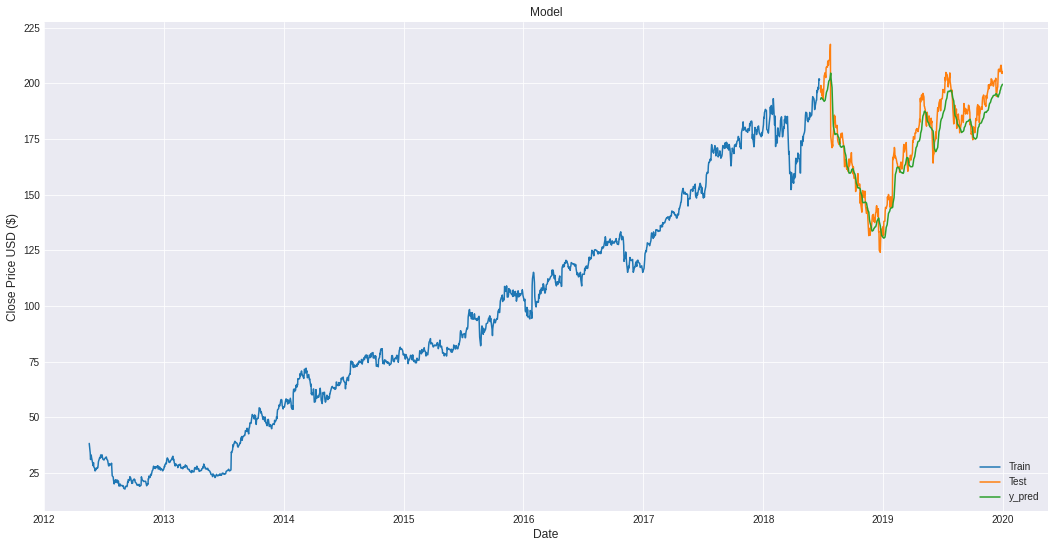

In [17]:
#Plot/Create the data for the graph
train = close[:train_len]
compare = close[train_len:]
compare['y_pred'] = y_pred
#Visualize the data
plt.figure(figsize=(18,9))
plt.title('Model')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price USD ($)', fontsize=12)
plt.plot(train['Close'])
plt.plot(compare[['Close', 'y_pred']])
plt.legend(['Train', 'Test', 'y_pred'], loc='lower right')
plt.show()

In [18]:
#comparing the predictions to the actual value
compare

,Close,y_pred
Date,,
2018-06-25,196.350006,192.788803
2018-06-26,199.000000,193.195801
2018-06-27,195.839996,193.516098
2018-06-28,196.229996,193.450516
2018-06-29,194.320007,193.243332
...,...,...
2019-12-24,205.119995,196.568130
2019-12-26,207.789993,197.354950
2019-12-27,208.100006,198.236984
